In [1]:
import seaborn as sns
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_pickle('./data/df_reduced_new.pkl')

In [3]:
df['outcome'].value_counts()

1    42221
0    16115
Name: outcome, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58336 entries, 0 to 60420
Data columns (total 62 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST                              58336 non-null  int64  
 1   FICO                              58336 non-null  int64  
 2   ORIGINAL_LOAN_AMOUNT              58336 non-null  float64
 3   TOT_MO_PMT                        58336 non-null  float64
 4   TERM                              58336 non-null  int64  
 5   LTV                               58336 non-null  float64
 6   MDL_YR                            58336 non-null  int64  
 7   EXTSN_CN                          58336 non-null  int64  
 8   COBUYER_CUSTOM_CREDIT_SCORE       58336 non-null  int64  
 9   BUYER_CUSTOM_CREDIT_SCORE         58336 non-null  int64  
 10  TOTAL_INCOME_AMOUNT               58336 non-null  float64
 11  DISPOSABLE_INCOME_AMOUNT          58336 non-null  float64
 12  BUYE

In [37]:
feature_list = ['CALL_DPD',
 'Dlnqnt_10_29_Cnt',
 'DAYS_SINCE_LAST_CALL',
 'DAYS_BETWEEN_FIRST_LAST',
 'TOT_MO_PMT',
 'ORIGINAL_LOAN_AMOUNT',
 'HIGHEST_LOAN_AMOUNT',
 'TOTAL_MONTHLY_PAYMENT_AMOUNT',
 'DISPOSABLE_INCOME_AMOUNT',
 'UNPAID_CASH_BALANCE_AMOUNT',
 'FICO',
 'BUYER_CUSTOM_CREDIT_SCORE',
 'LTV',
 'ORIGINAL_COMBINED_DEBT_TO_INCOME',
 'TOTAL_BUREAU_PAYMENT_AMOUNT',
 'Dlnqnt_30_59_Cnt',
 'TOTAL_INCOME_AMOUNT',
 'RESIDENCE_DURATION_NUMBER',
 'Dlnqnt_60_89_Cnt',
 'Dlnqnt_90_Cnt']

# Autoencoder

In [38]:
X = df[feature_list]
y = df['outcome']

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
# separate the normal and abnormal data
X_normal = X_scaled[y == 1]
y_normal = y[y == 1]
print('X_normal', X_normal.shape)
print('y_normal', y_normal.shape)

X_abnormal = X_scaled[y == 0]
y_abnormal = y[y == 0]
print('X_abnormal', X_abnormal.shape)
print('y_abnormal', y_abnormal.shape)

# will only train on the normal data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normal, y_normal, test_size=0.2, random_state=42)
print('X_train', X_train.shape)
print('y_train', y_train.shape)

X_normal (42221, 11)
y_normal (42221,)
X_abnormal (16115, 11)
y_abnormal (16115,)
X_train (33776, 11)
y_train (33776,)


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


# Build a deeper autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(14, activation="relu")(input_layer)
encoder = Dense(10, activation="relu")(encoder)
encoder = Dense(6, activation="relu")(encoder)

decoder = Dense(10, activation="relu")(encoder)
decoder = Dense(14, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=128, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/200
264/264 [==============================] - 1s 2ms/step - loss: 0.6309 - val_loss: 0.3925
Epoch 2/200
264/264 [==============================] - 0s 1ms/step - loss: 0.3484 - val_loss: 0.2794
Epoch 3/200
264/264 [==============================] - 0s 1ms/step - loss: 0.2922 - val_loss: 0.2420
Epoch 4/200
264/264 [==============================] - 0s 1ms/step - loss: 0.2547 - val_loss: 0.2086
Epoch 5/200
264/264 [==============================] - 0s 1ms/step - loss: 0.2172 - val_loss: 0.1802
Epoch 6/200
264/264 [==============================] - 0s 1ms/step - loss: 0.1837 - val_loss: 0.1592
Epoch 7/200
264/264 [==============================] - 0s 1ms/step - loss: 0.1621 - val_loss: 0.1448
Epoch 8/200
264/264 [==============================] - 0s 1ms/step - loss: 0.1427 - val_loss: 0.1192
Epoch 9/200
264/264 [==============================] - 0s 1ms/step - loss: 0.1114 - val_loss: 0.0940
Epoch 10/200
264/264 [==============================] - 0s 1ms/step - loss: 0.0902 - val_lo

504/504 [==============================] - 0s 574us/step


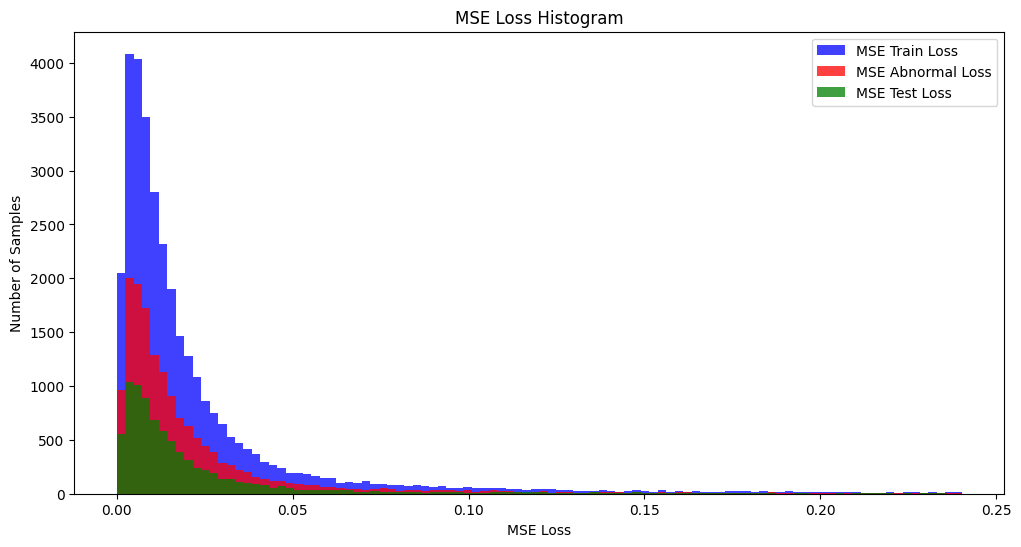

In [41]:
X_train_predictions = autoencoder.predict(X_train)
mse_train = np.mean(np.power(X_train - X_train_predictions, 2), axis=1)

X_test_predictions = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)

X_abnormal_predictions = autoencoder.predict(X_abnormal)
mse_abnormal = np.mean(np.power(X_abnormal - X_abnormal_predictions, 2), axis=1)

# Visualize MSE Loss Histogram to find optimal threshold
hist_range = (0, np.percentile(mse_abnormal, 98))
plt.figure(figsize=(12, 6))

# Plotting the histograms
plt.hist(mse_train, bins=100, range=hist_range, alpha=0.75, label='MSE Train Loss', color='blue')
plt.hist(mse_abnormal, bins=100, range=hist_range, alpha=0.75, label='MSE Abnormal Loss', color='red')
plt.hist(mse_test, bins=100, range=hist_range, alpha=0.75, label='MSE Test Loss', color='green')


# Setting labels, title, and legend
plt.xlabel('MSE Loss')
plt.ylabel('Number of Samples')
plt.title('MSE Loss Histogram')
plt.legend()

# Display the plot
plt.show()


In [46]:
# from sklearn.metrics import confusion_matrix, f1_score
# # Dynamic Threshold Tuning based on F1-score
# thresholds = np.linspace(0, np.percentile(mse_abnormal, 99), 100)
# scores = []
# for threshold in thresholds:
#     y_pred = (mse_abnormal > threshold).astype(int)
#     scores.append(f1_score(y_abnormal, y_pred))

# # Optimal threshold with maximum F1-score
# optimal_threshold = thresholds[np.argmax(scores)]
# print(f"Optimal threshold is {optimal_threshold}")

optimal_threshold = 0.05

# Confusion Matrix
y_pred_abnormal = (mse_abnormal > optimal_threshold).astype(int)
cm = confusion_matrix(y_abnormal, y_pred_abnormal)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[14207  1908]
 [    0     0]]


# Isolation Forest

In [43]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on the normal data
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_normal)

# Predict anomalies on the entire dataset
# Note: Isolation Forest returns 1 for normal and -1 for anomalies
predictions = iso_forest.predict(X_scaled)

# Convert predictions: 1 (normal) remains 1 and -1 (anomaly) becomes 0
anomaly_predictions = np.where(predictions == 1, 1, 0)


# Evaluate the performance using the confusion matrix
cm = confusion_matrix(y, anomaly_predictions)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[  761 15354]
 [ 2111 40110]]


# VAE

# add in feedback loop when deployment

In [ ]:
# Feedback Loop
def get_feedback(anomaly_predictions, true_labels, sample_size=100):
    """
    Simulate a feedback loop. 
    For simplicity, this function will randomly select a subset of predictions, 
    compare them with the true labels, and correct the predictions if necessary.
    """
    corrected_predictions = anomaly_predictions.copy()
    indices = np.random.choice(len(anomaly_predictions), sample_size, replace=False)
    for idx in indices:
        if corrected_predictions[idx] != true_labels[idx]:
            corrected_predictions[idx] = true_labels[idx]
    return corrected_predictions

# Get feedback and correct predictions
corrected_predictions = get_feedback(anomaly_predictions, y)

# Evaluate the performance using the confusion matrix
cm = confusion_matrix(y, corrected_predictions)
print("Confusion Matrix after feedback:")
print(cm)

# try on original dataset

In [51]:
df_reduced = pd.read_pickle('./data/df_reduced.pkl')

In [52]:
df_reduced['outcome'].value_counts()

1    23675
0     9399
Name: outcome, dtype: int64

In [53]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33074 entries, 0 to 33073
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Customer_ID                       33074 non-null  int64  
 1   CALL_MON_YEAR                     33074 non-null  object 
 2   TOTAL_MONTHLY_PAYMENT_AMOUNT      33074 non-null  int64  
 3   TOTAL_BUREAU_PAYMENT_AMOUNT       33074 non-null  int64  
 4   REVOLVING_TRADE_LINE_COUNT        33074 non-null  int64  
 5   REVOLVING_TRADE_LINE_PERCENT      33074 non-null  int64  
 6   FICO                              33074 non-null  int64  
 7   REVOLVING_CREDIT_MONTHLY_PAYMENT  33074 non-null  int64  
 8   REVOLVING_CREDIT_HIGH_AMOUNT      33074 non-null  int64  
 9   REVOLVING_CREDIT_BALANCE_AMOUNT   33074 non-null  int64  
 10  RESIDENCE_DURATION_NUMBER         33074 non-null  int64  
 11  TRADE_LINE_COUNT                  33074 non-null  int64  
 12  PERS

In [56]:
feature_list = ['CALL_DPD',
 'DLNQNT_10_29_CNT',
 'days_since_book',
 'PREVIOUS_MONTH_CALLS',
 'TOT_MO_PMT',
 'HIGHEST_LOAN_AMOUNT',
 'TOTAL_MONTHLY_PAYMENT_AMOUNT',
 'DISPOSABLE_INCOME_AMOUNT',
 'UNPAID_CASH_BALANCE_AMOUNT',
 'FICO',
 'BUYER_CUSTOM_CREDIT_SCORE',
 'ORIGINAL_COMBINED_DEBT_TO_INCOME',
 'TOTAL_BUREAU_PAYMENT_AMOUNT',
 'DLNQNT_30_59_CNT',
 'TOTAL_INCOME_AMOUNT',
 'RESIDENCE_DURATION_NUMBER',
 'DLNQNT_60_89_CNT',
 'DLNQNT_90_CNT']

In [57]:
X_reduced = df_reduced[feature_list]
y_reduced = df_reduced['outcome']

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_reduced = scaler.fit_transform(X_reduced)

In [59]:
# separate the normal and abnormal data
X_normal_reduced = X_scaled_reduced[y_reduced == 1]
y_normal_reduced = y_reduced[y_reduced == 1]
print('X_normal_reduced', X_normal_reduced.shape)
print('y_normal_reduced', y_normal_reduced.shape)

X_abnormal_reduced = X_scaled_reduced[y_reduced == 0]
y_abnormal_reduced = y_reduced[y_reduced == 0]
print('X_abnormal_reduced', X_abnormal_reduced.shape)
print('y_abnormal_reduced', y_abnormal_reduced.shape)

# will only train on the normal data
from sklearn.model_selection import train_test_split
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_normal_reduced, y_normal_reduced, test_size=0.2, random_state=42)
print('X_train_reduced', X_train_reduced.shape)
print('y_train_reduced', y_train_reduced.shape)

X_normal_reduced (23675, 18)
y_normal_reduced (23675,)
X_abnormal_reduced (9399, 18)
y_abnormal_reduced (9399,)
X_train_reduced (18940, 18)
y_train_reduced (18940,)


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


# Build a deeper autoencoder
input_dim = X_train_reduced.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(14, activation="relu")(input_layer)
encoder = Dense(10, activation="relu")(encoder)
encoder = Dense(6, activation="relu")(encoder)

decoder = Dense(10, activation="relu")(encoder)
decoder = Dense(14, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

history = autoencoder.fit(X_train_reduced, X_train_reduced, epochs=200, batch_size=128, shuffle=True, validation_data=(X_test_reduced, X_test_reduced))

Epoch 1/200
148/148 [==============================] - 1s 2ms/step - loss: 0.7202 - val_loss: 0.5546
Epoch 2/200
148/148 [==============================] - 0s 1ms/step - loss: 0.4908 - val_loss: 0.4355
Epoch 3/200
148/148 [==============================] - 0s 1ms/step - loss: 0.4108 - val_loss: 0.3699
Epoch 4/200
148/148 [==============================] - 0s 1ms/step - loss: 0.3526 - val_loss: 0.3187
Epoch 5/200
148/148 [==============================] - 0s 1ms/step - loss: 0.2977 - val_loss: 0.2633
Epoch 6/200
148/148 [==============================] - 0s 1ms/step - loss: 0.2619 - val_loss: 0.2389
Epoch 7/200
148/148 [==============================] - 0s 1ms/step - loss: 0.2446 - val_loss: 0.2278
Epoch 8/200
148/148 [==============================] - 0s 1ms/step - loss: 0.2332 - val_loss: 0.2167
Epoch 9/200
148/148 [==============================] - 0s 1ms/step - loss: 0.2238 - val_loss: 0.2086
Epoch 10/200
148/148 [==============================] - 0s 1ms/step - loss: 0.2157 - val_lo

294/294 [==============================] - 0s 703us/step


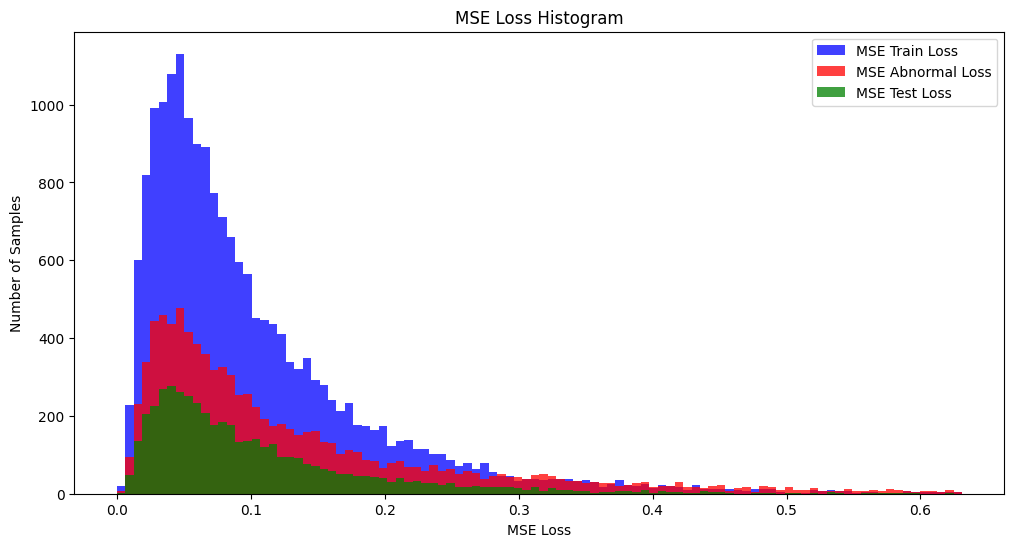

In [62]:
X_train_predictions_reduced = autoencoder.predict(X_train_reduced)
mse_train_reduced = np.mean(np.power(X_train_reduced - X_train_predictions_reduced, 2), axis=1)

X_test_predictions_reduced = autoencoder.predict(X_test_reduced)
mse_test_reduced = np.mean(np.power(X_test_reduced - X_test_predictions_reduced, 2), axis=1)

X_abnormal_predictions_reduced = autoencoder.predict(X_abnormal_reduced)
mse_abnormal_reduced = np.mean(np.power(X_abnormal_reduced - X_abnormal_predictions_reduced, 2), axis=1)

# Visualize MSE Loss Histogram to find optimal threshold
hist_range = (0, np.percentile(mse_abnormal_reduced, 98))
plt.figure(figsize=(12, 6))

# Plotting the histograms
plt.hist(mse_train_reduced, bins=100, range=hist_range, alpha=0.75, label='MSE Train Loss', color='blue')
plt.hist(mse_abnormal_reduced, bins=100, range=hist_range, alpha=0.75, label='MSE Abnormal Loss', color='red')
plt.hist(mse_test_reduced, bins=100, range=hist_range, alpha=0.75, label='MSE Test Loss', color='green')


# Setting labels, title, and legend
plt.xlabel('MSE Loss')
plt.ylabel('Number of Samples')
plt.title('MSE Loss Histogram')
plt.legend()

# Display the plot
plt.show()